In [16]:
# ========== [Imports] ==========
import shutil
from pathlib import Path
import random
from PIL import Image, ImageEnhance, ImageFilter
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import dirichlet
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import VGG19_Weights

In [17]:
# ========== [Settings & Constants] ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Path("/kaggle/input/hg14-handgesture14-dataset/HG14/HG14-Hand Gesture")
output = Path("/kaggle/working/HG14_split")
checkpoint_dir = output / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

img_size = (128, 128)
batch_size = 20
epochs = 50
num_classes = 14
early_stop_patience = 7

In [18]:
# ========== [Data Preparation] ==========
random.seed(42)
for class_folder in sorted(dataset.iterdir()):
    if class_folder.is_dir():
        images = list(class_folder.glob("*.jpg"))
        random.shuffle(images)

        total = len(images)
        test_count = int(0.10 * total)
        val_count = int(0.20 * (total - test_count))

        test_imgs = images[:test_count]
        val_imgs = images[test_count:test_count + val_count]
        train_imgs = images[test_count + val_count:]

        split_dict = {
            "training": train_imgs,
            "validation": val_imgs,
            "testing": test_imgs,
        }

        for split_name, split_images in split_dict.items():
            output_dir = output / split_name / class_folder.name
            output_dir.mkdir(parents=True, exist_ok=True)

            for img_path in split_images:
                shutil.copy(img_path, output_dir / img_path.name)

In [19]:
# ========== [Transforms & Dataloaders] ==========
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=str(output / 'training'), transform=transform)
val_dataset   = ImageFolder(root=str(output / 'validation'), transform=transform)
test_dataset  = ImageFolder(root=str(output / 'testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# ========== [Model Building Function] ==========

def build_model(base_model):
    if base_model == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    elif base_model == 'vgg19':
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    return model.to(device)

In [21]:
# ========== [Training Function with Early Stopping] ==========
def train_model(model, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f"{name} Epoch {epoch+1}/{epochs} - Val Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"/kaggle/working/{name}_best.pth")

    print(f"Best Validation Accuracy for {name}: {best_acc:.4f}")


In [22]:
# ========== [Prediction Function] ==========
def predict(model, loader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            all_outputs.append(torch.softmax(outputs, dim=1).cpu())
    return torch.cat(all_outputs)

In [23]:
# ========== [Ensemble Prediction Function] ==========
def ensemble_predictions(pred1, pred2, test_dataset, num_trials=1000):
    best_acc = 0.0
    best_weights = None
    final_preds = None

    labels = torch.tensor([label for _, label in test_dataset.samples])

    for _ in range(num_trials):
        weights = dirichlet([1, 1])
        ensemble = weights[0] * pred1 + weights[1] * pred2
        predicted = torch.argmax(ensemble, dim=1)
        acc = (predicted == labels).float().mean().item()

        if acc > best_acc:
            best_acc = acc
            best_weights = weights
            final_preds = predicted

    print(f"Best Ensemble Accuracy: {best_acc:.4f}")
    print(f"Best Weights: {best_weights}")
    return final_preds

In [24]:
# ========== [Run Models & Ensemble] ==========
vgg19 = build_model('vgg19')
mobilenet = build_model('mobilenet_v2')

train_model(vgg19, 'vgg19')
train_model(mobilenet, 'mobilenet_v2')

vgg19.load_state_dict(torch.load('/kaggle/working/vgg19_best.pth'))
mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_v2_best.pth'))

vgg_preds = predict(vgg19, test_loader)
mob_preds = predict(mobilenet, test_loader)

ensemble_predictions(mob_preds, vgg_preds, test_dataset)

vgg19 Epoch 1/50 - Val Accuracy: 0.9500
vgg19 Epoch 2/50 - Val Accuracy: 0.9869
vgg19 Epoch 3/50 - Val Accuracy: 0.9913
vgg19 Epoch 4/50 - Val Accuracy: 0.9722
vgg19 Epoch 5/50 - Val Accuracy: 0.9532
vgg19 Epoch 6/50 - Val Accuracy: 0.9925
vgg19 Epoch 7/50 - Val Accuracy: 0.9968
vgg19 Epoch 8/50 - Val Accuracy: 0.9992
vgg19 Epoch 9/50 - Val Accuracy: 0.9873
vgg19 Epoch 10/50 - Val Accuracy: 0.9976
vgg19 Epoch 11/50 - Val Accuracy: 0.9976
vgg19 Epoch 12/50 - Val Accuracy: 0.9960
vgg19 Epoch 13/50 - Val Accuracy: 0.9984
vgg19 Epoch 14/50 - Val Accuracy: 0.9988
vgg19 Epoch 15/50 - Val Accuracy: 0.9964
vgg19 Epoch 16/50 - Val Accuracy: 0.9984
vgg19 Epoch 17/50 - Val Accuracy: 0.9365
vgg19 Epoch 18/50 - Val Accuracy: 0.9956
vgg19 Epoch 19/50 - Val Accuracy: 0.9980
vgg19 Epoch 20/50 - Val Accuracy: 1.0000
vgg19 Epoch 21/50 - Val Accuracy: 1.0000
vgg19 Epoch 22/50 - Val Accuracy: 1.0000
vgg19 Epoch 23/50 - Val Accuracy: 1.0000
vgg19 Epoch 24/50 - Val Accuracy: 1.0000


KeyboardInterrupt: 

In [20]:
vgg19 = build_model('vgg19')
mobilenet = build_model('mobilenet_v2')

vgg19.load_state_dict(torch.load('/kaggle/working/vgg19_best.pth'))
mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_v2_best.pth'))

vgg19.eval()
mobilenet.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
vgg_preds = predict(vgg19, test_loader)  # Shape: [N, 14]
mob_preds = predict(mobilenet, test_loader)  # Shape: [N, 14]

In [24]:
best_weights = [0.46720897, 0.53279103]
ensemble_output = best_weights[0] * mob_preds + best_weights[1] * vgg_preds
final_preds = torch.argmax(ensemble_output, dim=1)

In [25]:
true_labels = torch.tensor([label for _, label in test_dataset.samples])
accuracy = (final_preds == true_labels).float().mean().item()
print(f"Final Ensemble Test Accuracy: {accuracy:.4f}")

Final Ensemble Test Accuracy: 0.9986


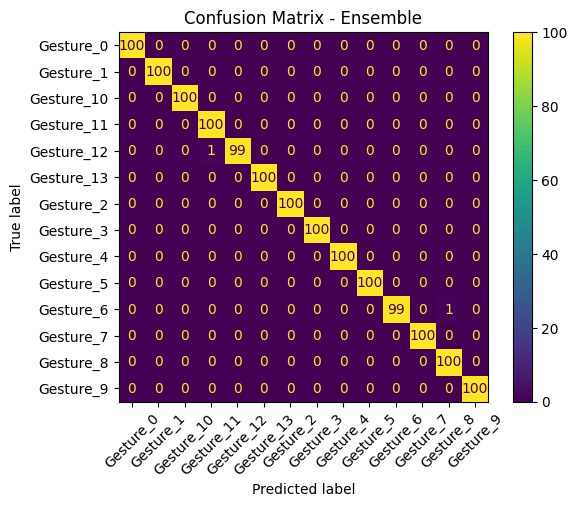

In [26]:
cm = confusion_matrix(true_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Ensemble")
plt.show()

In [27]:
np.save("/kaggle/working/ensemble_weights.npy", best_weights)

# Usage

In [3]:
# Load required model weight enums
from torchvision.models import MobileNet_V2_Weights, VGG19_Weights

# Rebuild the models
mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet.classifier = nn.Sequential(
    nn.Linear(mobilenet.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 14)
)

vgg19 = models.vgg19(weights=VGG19_Weights.DEFAULT)
vgg19.classifier[6] = nn.Sequential(
    nn.Linear(vgg19.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 14)
)

# Load saved weights
mobilenet.load_state_dict(torch.load("/kaggle/input/fted-mobilenet-vgg19/pytorch/default/1/mobilenet_v2_best.pth"))
vgg19.load_state_dict(torch.load("/kaggle/input/fted-mobilenet-vgg19/pytorch/default/1/vgg19_best.pth"))

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device).eval()
vgg19 = vgg19.to(device).eval()


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 197MB/s] 


In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']  # class names


In [6]:
from PIL import Image
import torch

def predict_image(img_path, weights):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out_mob = torch.softmax(mobilenet(img_tensor), dim=1)
        out_vgg = torch.softmax(vgg19(img_tensor), dim=1)

        ensemble_out = weights[0] * out_mob + weights[1] * out_vgg
        pred_idx = torch.argmax(ensemble_out, dim=1).item()
        return class_labels[pred_idx]


In [7]:
best_weights = [0.46720897, 0.53279103]  # Replace with your actual values from earlier

# Predict
image_path = "/kaggle/input/idkkkk/0.jpg"
prediction = predict_image(image_path, best_weights)
print("Predicted class:", prediction)


Predicted class: 11


In [9]:
image_path = "/kaggle/input/idkkkk/5.png"
prediction = predict_image(image_path, best_weights)
print("Predicted class:", prediction)

Predicted class: 8


# Mobile Net

In [11]:
mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet.classifier = nn.Sequential(
    nn.Linear(mobilenet.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 14)
)
mobilenet.load_state_dict(torch.load("/kaggle/input/fted-mobilenet-vgg19/pytorch/default/1/mobilenet_v2_best.pth"))
mobilenet = mobilenet.to(device).eval()

In [12]:
def predict_with_mobilenet(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = mobilenet(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        return class_labels[pred_idx], probs.squeeze().cpu().numpy()

In [13]:
image_path = "/kaggle/input/idkkkk/0.jpg"
label, probs = predict_with_mobilenet(image_path)
print(f"Predicted label: {label}")

Predicted label: 5


In [14]:
image_path = "/kaggle/input/idkkkk/5.png"
label, probs = predict_with_mobilenet(image_path)
print(f"Predicted label: {label}")

Predicted label: 8


In [ ]:
image_path = "/kaggle/input/idkkkk/5.png"
label, probs = predict_with_mobilenet(image_path)
print(f"Predicted label: {label}")